In [3]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary, TensoredLibrary
from sklearn.metrics import log_loss

In [145]:
class featureSpace:
    def __init__(self):
        self.rs = None # fitted robust scaler
        self.mm = None # fitted minMax scaler
        self.calDataNorm = None # normalized calibration data
        self.calDataTS = None # time series calibration data
        self.testDataNorm = None # normalized projected data
        self.testDataTS = None # time series projected data
        self.epsilon = None # tolerance threshold 
        self.learnedMetric = None # metric function learned from calibration data
        self.pca_calibrated = None # low dimensional embedding of the calibrated space
        self.sig = FunctionTransformer(self.sigmoid, kw_args={'theta': 1.35})
        self.pca_fit = None
        self.epsilon = 1 # optimal threshold
    
    @staticmethod
    def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))

    def fit(self, cal_samples, cal_ts):
        """Normalize the calibration data"""
        self.calDataTs = cal_ts
        self.rs = RobustScaler().fit(cal_samples.iloc[:,:22])
        rs_transformed = self.rs.transform(cal_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        self.mm = MinMaxScaler().fit(sig_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.calDataNorm = pd.DataFrame(mm_transformed)
        self.calDataNorm['N'] = cal_samples['N'].values
        self.calDataNorm['eta'] = cal_samples['eta'].values
        self.calDataNorm['mu'] = cal_samples['mu'].values
        self.calDataNorm['model'] = cal_samples['model'].values
        self.pca_fit = PCA(n_components=2).fit(self.calDataNorm.iloc[:,:22])
    
    # function to evaluate the trained space using new data - to be used with external eval function which
    # feeds in new training data, test data and the log/loss + accuracy is returned for each iteration of a loop
    def evalaute(self, test_samples, test_ts, radii):
        """Evaluate the calibrated space on new data
        Args:
            test_samples (pd.DataFrame): new data to be evaluated
            test_ts (pd.DataFrame): time series data for new data
            radii (list): list of radii to be evaluated
        Returns:
            (pd.DataFrame): dataframe containing the log loss and accuracy for each radius
            Predicted probabilities for each sample for each radius
            """
        self.testDataTS = test_ts
        rs_transformed = self.rs.transform(test_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.testDataNorm = pd.DataFrame(mm_transformed)
        self.testDataNorm['N'] = test_samples['N'].values
        self.testDataNorm['eta'] = test_samples['eta'].values
        self.testDataNorm['mu'] = test_samples['mu'].values
        self.testDataNorm['model'] = test_samples['model'].values
        
        # fit ABC radius Classifier and evaluate
        acc = list()
        predicted_proba = list() # list of predicted probabilities for each test sample
        logloss_vals = list()
        for r in radii:
            abc = RadiusNeighborsClassifier(radius=r, outlier_label='most_frequent')
            abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
            y_pred = abc.predict_proba(self.testDataNorm.iloc[:,:22])
            predicted_proba.append(y_pred)
            logloss_vals.append(log_loss(self.testDataNorm['model'], y_pred))
            acc.append(abc.score(self.testDataNorm.iloc[:,:22], self.testDataNorm['model']))
        results = pd.DataFrame({'radius': radii, 'accuracy': acc, 'logloss': logloss_vals})
        return results, predicted_proba

    # function to compute the distributions of pairwise distances within and between classes in the calibrated space
    #def pairwiseDist(self, showPlot = True):


    def predict(self, proj_samples, proj_ts, showPlot=False): # project new data into the calibrated space
        self.projDataTS = proj_ts
        rs_transformed = self.rs.transform(proj_samples.iloc[:,:22])
        sig_transformed = self.sig.transform(rs_transformed)
        mm_transformed = self.mm.transform(sig_transformed)
        self.projDataNorm = pd.DataFrame(mm_transformed)
        self.projDataNorm['N'] = proj_samples['N'].values
        self.projDataNorm['eta'] = proj_samples['eta'].values
        self.projDataNorm['mu'] = proj_samples['mu'].values
        self.projDataNorm['model'] = proj_samples['model'].values
        # project new data into calibrated space
        #predicted_proba = list()
        abc = RadiusNeighborsClassifier(radius=self.epsilon, outlier_label='most_frequent')
        abc.fit(self.calDataNorm.iloc[:,:22], self.calDataNorm['model'])
        y_pred = abc.predict_proba(self.projDataNorm.iloc[:,:22])

        if showPlot:
            fig = plt.figure(figsize=(8,5))
            plt.ylabel('P(M|D)', fontsize=15)
            plt.xlabel('Model', fontsize=15)
            models = abc.classes_
            plt.title(f"True = {proj_samples['model'].values[0]}, Predicted = {abc.predict(self.projDataNorm.iloc[:,:22])[0]}, $\epsilon = {self.epsilon}$", fontsize=15)
            sns.barplot(x=models, y=y_pred[0])
            plt.show()
        
        return [y_pred, abc.predict(self.projDataNorm.iloc[:,:22]), abc.classes_]


    def pcaViz(self, return_df = False): # generalize to other projection technqiues
        """Visualize the calibrated space in 2D using PCA"""
        pca_calibrated = self.pca_fit.transform(self.calDataNorm.iloc[:,:22])
        plt.figure(figsize=(12,8))
        plt.title('Unoptimised Space, PCA')
        sns.scatterplot(x=pca_calibrated[:,0], y=pca_calibrated[:,1], hue=self.calDataNorm['model'], s=3 )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
        if return_df:
            pca_calibrated = pd.DataFrame(pca_calibrated).rename(columns={0:'PC1', 1:'PC2'})
            pca_calibrated['N'] = self.calDataNorm['N']
            pca_calibrated['eta'] = self.calDataNorm['eta']
            pca_calibrated['mu'] = self.calDataNorm['mu']
            pca_calibrated['model'] = self.calDataNorm['model']
            return pca_calibrated

    def setEpsilon(self, epsilon):
        """Manually set the tolerance threshold"""
        self.epsilon = epsilon

In [214]:
class LogMap:
    def __init__(self):
        self.mu = None
        self.model = 'LogMap'
        self.transients = 1000
        # store sampling range
        self.mu_min = 2.5
        self.mu_max = 3.95
    
    def set_mu(self, mu):
        self.mu = mu
    
    # generate from deterministic logmap with measurement noise
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.mu * x[i-1, 0] * (1-x[i-1, 0])
            x[i, 1] = self.mu

        # add measurement noise
        noise = np.zeros((N, 2))
        noise[:, 0] = eta_measurement * np.random.randn(N)

        return x[self.transients:] + noise
    
    # generate from logmap with intrinsic process noise (and measurement noise)
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = np.maximum(np.minimum(self.mu * x[i-1, 0] * (1 - x[i - 1, 0]) + eta_intrinsic * np.random.randn(), 1), 0)
            x[i, 1] = self.mu
        
        # add measurement noise if specified
        if eta_measurement:
            noise = np.zeros((N, 2))
            noise[:, 0] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class HenonMap:
    def __init__(self):
        self.mu = None
        self.model = 'HenonMap'
        self.transients = 1000
        self.b = 0.3
        # store sampling range
        self.mu_min = 0.1
        self.mu_max = 1.0
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = 1 - self.mu * x[i-1, 0]**2 + x[i-1, 1]
            x[i, 1] = self.b * x[i-1, 0] 
            x[i, 2] = self.mu

        # add measurement noise
        noise = np.zeros((N, 3))
        noise[:, :2] = eta_measurement * np.random.randn(N,2)

        return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = 1 - self.mu * x[i-1, 0]**2 + x[i-1, 1] + eta_intrinsic * np.random.randn()
            x[i, 1] = self.b * x[i-1, 0] + eta_intrinsic * np.random.randn()
            x[i, 2] = self.mu
        
        # add measurement noise
        if eta_measurement:
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class BurgersMap:
    def __init__(self):
        self.mu = None
        self.model = 'BurgersMap'
        self.transients = 1000
        self.a = 0.75
        # store sampling range
        self.mu_min = 0.9
        self.mu_max = 1.8

    def set_mu(self, mu):
        self.mu = mu
    
    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 
            x[i, 1] = self.mu * x[i-1, 1] + x[i-1, 0] * x[i-1, 1]
            x[i, 2] = self.mu
        
        # add measurement noise
        noise = np.zeros((N, 3))
        noise[:, :2] = eta_measurement * np.random.randn(N,2)
        return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N + self.transients, 3))
        x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.a * x[i-1, 0] - x[i-1,1]**2 + eta_intrinsic * np.random.randn()
            x[i, 1] = self.mu * x[i-1, 1] + x[i-1, 0] * x[i-1, 1] + eta_intrinsic * np.random.randn()
            x[i, 2] = self.mu
        
        # add measurement noise
        if eta_measurement:
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N,2)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]

class CubicMap:
    def __init__(self):
        self.mu = None
        self.model = 'CubicMap'
        self.transients = 1000
        # store sampling range
        self.mu_min = 1.8
        self.mu_max = 3.0
    
    def set_mu(self, mu):
        self.mu = mu

    # generate data such that it is also compatible with SINDy
    def generate_deterministic(self, N, eta_measurement):
            x = np.zeros((N + self.transients, 2))
            x[0] = [np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  self.mu * x[i-1, 0] * (1-x[i-1, 0]**2)
                x[i, 1] =  self.mu
            
            # add measurement noise
            noise = np.zeros((N, 1))
            noise[:, 0] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
    
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
            x = np.zeros((N + self.transients, 2))
            x[0] = [np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  self.mu * x[i-1, 0] * (1-x[i-1, 0]**2) + eta_intrinsic * np.random.randn()
                x[i, 1] =  self.mu
            
            # add measurement noise
            if eta_measurement:
                noise = np.zeros((N, 1))
                noise[:, 0] = eta_measurement * np.random.randn(N)
                return x[self.transients:] + noise
            else:
               return x[self.transients:] 
         
class TinkerBellMap:
    # https://www.mdpi.com/2076-3417/8/12/2640
    def __init__(self):
        self.mu = None
        self.model = 'TinkerBellMap'
        self.transients = 1000
        self.mu_min = 0.1 # here mu (critical param is arbitrarily set to c as per Sprott's definition)
        self.mu_max = 1.6
        self.a = 0.9
        self.b = -0.6013
        self.d = 0.5 
    
    def set_mu(self, mu):
        self.mu = mu

    def generate_deterministic(self, N, eta_measurement):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1]
                x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1]
                x[i, 2] =  self.mu
            
            # add measurement noise
            noise = np.zeros((N, 3))
            noise[:, :2] = eta_measurement * np.random.randn(N,2)
            return x[self.transients:] + noise

    # generate data such that it is also compatible with SINDy
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
            x = np.zeros((N + self.transients, 3))
            x[0] = [np.random.uniform(low=0.001, high=0.01), np.random.uniform(low=0.001, high=0.01), self.mu]
            for i in range(1, N+self.transients):
                x[i, 0] =  x[i-1, 0]**2 - x[i-1, 1]**2 + self.a * x[i-1, 0] + self.b * x[i-1, 1] + eta_intrinsic * np.random.randn()
                x[i, 1] =  2 * x[i-1, 0] * x[i-1, 1] + self.mu * x[i-1, 0] + self.d * x[i-1, 1] + eta_intrinsic * np.random.randn()
                x[i, 2] =  self.mu
            
            # add measurement noise
            if eta_measurement:
                noise = np.zeros((N, 3))
                noise[:, :2] = eta_measurement * np.random.randn(N,2)
                return x[self.transients:] + noise
            else:
                return x[self.transients:]


class SineMap:
    def __init__(self):
        self.mu = None
        self.model = 'SineMap'
        self.transients = 1000
        # store sampling range
        self.mu_min = 0.6
        self.mu_max = 1.5
    
    def set_mu(self, mu):
        self.mu = mu
    
    # generate from deterministic logmap with measurement noise
    def generate_deterministic(self, N, eta_measurement):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.mu * np.sin(np.pi * x[i-1, 0])
            x[i, 1] = self.mu

        # add measurement noise
        noise = np.zeros((N, 2))
        noise[:, 0] = eta_measurement * np.random.randn(N)

        return x[self.transients:] + noise
    
    # generate from logmap with intrinsic process noise (and measurement noise)
    def generate_stochastic(self, N, eta_intrinsic, eta_measurement=None):
        x = np.zeros((N+self.transients, 2))
        x[0] = [np.random.uniform(low=0, high=0.5), self.mu]
        for i in range(1, N+self.transients):
            x[i, 0] = self.mu * np.sin(np.pi * x[i-1, 0]) + eta_intrinsic * np.random.randn()
            x[i, 1] = self.mu
        
        # add measurement noise if specified
        if eta_measurement:
            noise = np.zeros((N, 2))
            noise[:, 0] = eta_measurement * np.random.randn(N)
            return x[self.transients:] + noise
        else:
            return x[self.transients:]
    
         

In [147]:
def generate_LogMap(N_val, eta_val, seed=None):
    # generate samples from a particular map for comparison between methods
    # return sols list (ts) for SINDy and df for our method
    mus = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 3.8, 3.85, 3.9, 3.95] # mu windows to sample from - taken from SINDy paper
    if seed is not None:
        np.random.seed(seed)
    sols_list = list()
    for mu in mus:
        x = LogMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['LogMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_HenonMap(N_val, eta_val, seed=None):
    # generate samples from a particular map for comparison between methods
    # return sols list (ts) for SINDy and df for our method
    mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    if seed is not None:
        np.random.seed(seed)
    sols_list = list()
    for mu in mus:
        x = HenonMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['HenonMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_BurgersMap(N_val, eta_val, seed=None):
    mus = [0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.65, 1.7]
    if seed is not None:
        np.random.seed(seed)
    sols_list = list()
    for mu in mus:
        x = BurgersMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['BurgersMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_CubicMap(N_val, eta_val, seed=None):
    mus = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]
    if seed is not None:
        np.random.seed(seed)
    sols_list = list()
    for mu in mus:
        x = CubicMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['CubicMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_TinkerBellMap(N_val, eta_val, seed=None):
    mus = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    if seed is not None:
        np.random.seed(seed)
    sols_list = list()
    for mu in mus:
        x = TinkerBellMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['TinkerBellMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts

def generate_SineMap(N_val, eta_val, seed=None):
    mus = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    if seed is not None:
        np.random.seed(seed)
    sols_list = list()
    for mu in mus:
        x = SineMap()
        x.set_mu(mu)
        sol = x.generate_deterministic(N_val, eta_val)
        sols_list.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features)
    df['N'] = [N_val for i in range(len(sols_list))]
    df['mu'] = mus
    df['eta'] = [eta_val for i in range(len(sols_list))]
    df['model'] = ['SineMap' for i in range(len(sols_list))] 
    ts = sols_list
    return df, ts


In [215]:
def sample_maps(num_samples, N_val=None, eta_val=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    models = [LogMap(), HenonMap(), BurgersMap(), TinkerBellMap(), CubicMap()]
    sel_model = list()
    lengths = list()
    mus = list()
    etas = list()
    sols = list()
    for i in range(num_samples):
        model = np.random.choice(models) # pick a model
        sel_model.append(model)
        mu = np.random.uniform(low=model.mu_min, high=model.mu_max) # pick a mu
        mus.append(mu)
        if N_val is None:
            N = np.random.randint(low=50, high=10000)
        else:
            N = N_val
        lengths.append(N)
        if eta_val is None:
            eta = np.random.uniform(low=0., high=0.1) # pick a noise level
        else:
            eta = eta_val
        etas.append(eta)
        model.set_mu(mu)
        sol = model.generate_deterministic(N, eta)
        sols.append(sol)
    
    # extract features
    features = np.array([catch22.catch22_all(sols[i][:,0])['values'] for i in range(len(sols))])
    df = pd.DataFrame(features)
    df['N'] = lengths
    df['mu'] = mus
    df['eta'] = etas
    df['model'] = [sel_model[i].model for i in range(len(sel_model))]
    ts = sols
    return df, ts


In [149]:
def is_within_tolerance(ground_truth, obtained_value, tolerance=0.1):
    # tolerance is a percentage ie. 0.1 = 10%
    lower_bound = np.abs(ground_truth) * (1 - tolerance)
    upper_bound = np.abs(ground_truth) * (1 + tolerance)

    return lower_bound <= np.abs(obtained_value) <= upper_bound

In [150]:
def evaluate_space(model, num_iter, cal_data_length, test_data_length, showPlot=True):
    meta_acc = list()
    meta_logloss = list()
    radii = np.linspace(0.1, 2, 20)
    for i in range(num_iter):
        print(f'iteration: {i}')
        # generate calibration data 
        df_cal, ts_cal = sample_maps(cal_data_length)
        df_cal = df_cal.dropna()
        print(len(df_cal))
        # generate test data
        df_test, ts_test = sample_maps(test_data_length) 
        df_test = df_test.dropna()
        print(len(df_test))
        # train the space
        model.fit(df_cal, ts_cal)
        df_eval, predicted_proba = space.evalaute(df_test, ts_test, radii)
        meta_acc.append(df_eval['accuracy'].values)
        meta_logloss.append(df_eval['logloss'].values)
    
    optimal_epsilon_ll = radii[np.argmin(np.mean(meta_logloss, axis=0))]
    print(f'Optimal Epsilon (LogLoss): {optimal_epsilon_ll}')
    optimal_epsilon_acc = radii[np.argmax(np.mean(meta_acc, axis=0))]
    print(f'Optimal Epsilon (Accuracy): {optimal_epsilon_acc}')
    
    if showPlot:
        fig, ax = plt.subplots(1,2, figsize=(22,8))
        ax[0].errorbar(radii, np.mean(meta_acc, axis=0), yerr=np.std(meta_acc, axis=0), label='std', capsize=3)
        ax[0].axvline(x=radii[np.argmax(np.mean(meta_acc, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[0].set_xlabel('$\epsilon$')
        ax[0].set_ylabel('Accuracy')

        ax[1].errorbar(radii, np.mean(meta_logloss, axis=0), yerr=np.std(meta_logloss, axis=0), label='std', capsize=3)
        ax[1].axvline(x=radii[np.argmin(np.mean(meta_logloss, axis=0))], c='r', linestyle='--', label='optimal threshold')
        ax[1].set_xlabel('$\epsilon$')
        ax[1].set_ylabel('Log Loss')
        plt.show()
    

In [151]:
def isLogMap_sindy(test_ts, tol=0.1, poly_order=3, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance


    # set SINDy hyperparameters
    library = ps.PolynomialLibrary(degree=poly_order) # restrict to 3rd order polynomials by default
    lambda_range = [0.1, 0.2, 0.3, 0.4]

    for sparsity in lambda_range:
        optimizer = ps.STLSQ(threshold=sparsity)
        model = ps.SINDy(
        optimizer=optimizer, 
        feature_library=library, 
        discrete_time=True,
        feature_names=['x', 'mu'],
        )

        model.fit(test_ts, multiple_trajectories=True, quiet=True)
        if showEq:
            model.print()
        coeffs = model.coefficients()
        x_coeffs, mu_coeffs = coeffs[0], coeffs[1]

        non_zero_idx_x, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(mu_coeffs)[0]

        expected_non_zero_idx_x = {4: 1.0, 7: -1.0}
        expected_non_zero_idx_mu = {2: 1.0}

        if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_mu) == list(expected_non_zero_idx_mu.keys()):
            valid_coeffs = True
            for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
                if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                    print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_mu.items():
                if not is_within_tolerance(ground_truth_coeff, mu_coeffs[idx], tol):
                    valid_coeffs = False
                    break

            if valid_coeffs:
                return True

    return False

In [152]:
def isHenonMap_sindy(test_ts, tol=0.1, poly_order=3, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance


    # set SINDy hyperparameters
    library = ps.PolynomialLibrary(degree=poly_order) # restrict to 3rd order polynomials by default
    lambda_range = [0.1, 0.2, 0.3, 0.4]

    for sparsity in lambda_range:
        optimizer = ps.STLSQ(threshold=sparsity)
        model = ps.SINDy(
        optimizer=optimizer, 
        feature_library=library, 
        discrete_time=True,
        feature_names=['x', 'y', 'mu'],
        )

        model.fit(test_ts, multiple_trajectories=True, quiet=True)
        if showEq:
            model.print()
        coeffs = model.coefficients()
        x_coeffs, y_coeffs, mu_coeffs = coeffs[0], coeffs[1], coeffs[2]

        non_zero_idx_x, non_zero_idx_y, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0], np.nonzero(mu_coeffs)[0]

        expected_non_zero_idx_x = {0: 1.0, 2: 1.0, 12: -1.0}
        expected_non_zero_idx_y = {1: 0.3}
        expected_non_zero_idx_mu = {3: 1.0}

        if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()) and list(non_zero_idx_mu) == list(expected_non_zero_idx_mu.keys()):
            valid_coeffs = True
            for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
                if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                    print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
                if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_mu.items():
                if not is_within_tolerance(ground_truth_coeff, mu_coeffs[idx], tol):
                    valid_coeffs = False
                    break

            if valid_coeffs:
                return True

    return False

        

In [153]:
def isBurgersMap_sindy(test_ts, tol=0.1, poly_order=3, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance


    # set SINDy hyperparameters
    library = ps.PolynomialLibrary(degree=poly_order) # restrict to 3rd order polynomials by default
    lambda_range = [0.1, 0.2, 0.3, 0.4]

    for sparsity in lambda_range:
        optimizer = ps.STLSQ(threshold=sparsity)
        model = ps.SINDy(
        optimizer=optimizer, 
        feature_library=library, 
        discrete_time=True,
        feature_names=['x', 'y', 'mu'],
        )

        model.fit(test_ts, multiple_trajectories=True, quiet=True)
        if showEq:
            model.print()
        coeffs = model.coefficients()
        x_coeffs, y_coeffs, mu_coeffs = coeffs[0], coeffs[1], coeffs[2]

        non_zero_idx_x, non_zero_idx_y, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0], np.nonzero(mu_coeffs)[0]


        expected_non_zero_idx_x = {1: 0.75, 7: -1.0}
        expected_non_zero_idx_y = {5: 1.0, 8: 1.0}
        expected_non_zero_idx_mu = {3: 1.0}

        if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()) and list(non_zero_idx_mu) == list(expected_non_zero_idx_mu.keys()):
            valid_coeffs = True
            for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
                if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                    print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
                if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_mu.items():
                if not is_within_tolerance(ground_truth_coeff, mu_coeffs[idx], tol):
                    valid_coeffs = False
                    break

            if valid_coeffs:
                return True

    return False

In [230]:
def isCubicMap_sindy(test_ts, tol=0.1, poly_order=4, showEq=False):
    # strict criteria -> must have 2 non-zero coefficients for x and 1 non-zero coefficient for mu
    # non-strict criteria -> can more (unexpected) coefficients as long as they are within the tolerance


    # set SINDy hyperparameters
    library = ps.PolynomialLibrary(degree=poly_order) 
    lambda_range = [0.1, 0.2, 0.3, 0.4]

    for sparsity in lambda_range:
        optimizer = ps.STLSQ(threshold=sparsity)
        model = ps.SINDy(
        optimizer=optimizer, 
        feature_library=library, 
        discrete_time=True,
        feature_names=['x', 'mu'],
        )

        model.fit(test_ts, multiple_trajectories=True, quiet=True)
        if showEq:
            model.print()
        coeffs = model.coefficients()
        x_coeffs, mu_coeffs = coeffs[0], coeffs[1]

        non_zero_idx_x, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(mu_coeffs)[0]

        expected_non_zero_idx_x = {4: 1.0, 11: -1.0}
        expected_non_zero_idx_mu = {2: 1.0}

        if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_mu) == list(expected_non_zero_idx_mu.keys()):
            valid_coeffs = True
            for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
                if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_mu.items():
                if not is_within_tolerance(ground_truth_coeff, mu_coeffs[idx], tol):
                    valid_coeffs = False
                    break

            if valid_coeffs:
                return True

    return False



In [155]:
def isTinkerBellMap_sindy(test_ts, tol=0.1, poly_order=4, showEq=False):
    library = ps.PolynomialLibrary(degree=poly_order)
    lambda_range = [0.1, 0.2, 0.3, 0.4]

    for sparsity in lambda_range:
        optimizer = ps.STLSQ(threshold=sparsity)
        model = ps.SINDy(
            optimizer=optimizer,
            feature_library=library,
            discrete_time=True,
            feature_names=['x', 'y', 'mu'],
        )

        model.fit(test_ts, multiple_trajectories=True, quiet=True)
        if showEq:
            model.print()
        coeffs = model.coefficients()
        x_coeffs, y_coeffs, mu_coeffs = coeffs[0], coeffs[1], coeffs[2]

        non_zero_idx_x, non_zero_idx_y, non_zero_idx_mu = np.nonzero(x_coeffs)[0], np.nonzero(y_coeffs)[0], np.nonzero(mu_coeffs)[0]

        expected_non_zero_idx_x = {1: 0.9, 2: -0.6013, 4: 1, 7: -1}
        expected_non_zero_idx_y = {2: 0.5, 5: 2, 6: 1}
        expected_non_zero_idx_mu = {3: 1}

        if list(non_zero_idx_x) == list(expected_non_zero_idx_x.keys()) and list(non_zero_idx_y) == list(expected_non_zero_idx_y.keys()) and list(non_zero_idx_mu) == list(expected_non_zero_idx_mu.keys()):
            valid_coeffs = True
            for idx, ground_truth_coeff in expected_non_zero_idx_x.items():
                if not is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol):
                    print(idx, is_within_tolerance(ground_truth_coeff, x_coeffs[idx], tol))
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_y.items():
                if not is_within_tolerance(ground_truth_coeff, y_coeffs[idx], tol):
                    valid_coeffs = False
                    break
            for idx, ground_truth_coeff in expected_non_zero_idx_mu.items():
                if not is_within_tolerance(ground_truth_coeff, mu_coeffs[idx], tol):
                    valid_coeffs = False
                    break

            if valid_coeffs:
                return True

    return False


In [227]:
def isMap_isa(space, mapName, check_df, check_ts):
    # assume space is already calibrated/fit
    probs, preds, classes = space.predict(check_df, check_ts)
    avg_probs = np.mean(probs, axis=0) # soft voting scheme
    avg_index = np.argmax(avg_probs) 
    predicted_class = classes[avg_index]
    if predicted_class == mapName:
        return True
    else:
        return False

## Calibrate Space

iteration: 0
5000
1000
iteration: 1
5000
1000
iteration: 2
5000
1000
iteration: 3
5000
1000
iteration: 4
5000
1000
Optimal Epsilon (LogLoss): 1.0999999999999999
Optimal Epsilon (Accuracy): 0.7999999999999999


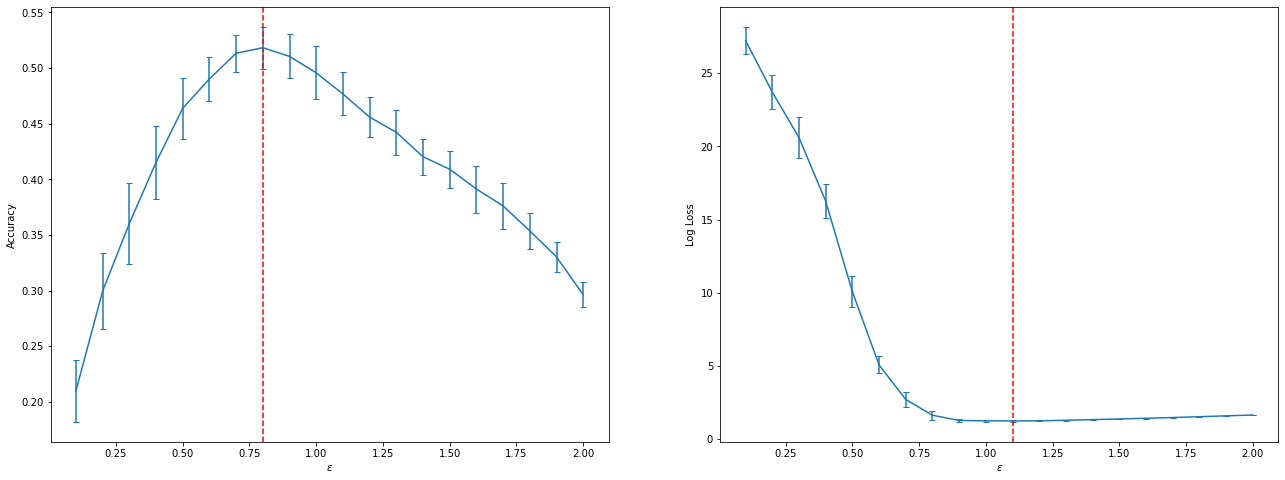

In [157]:
evaluate_space(space, num_iter = 5, cal_data_length=5000, test_data_length=1000)

In [217]:
df, ts = sample_maps(20000, seed=42)

In [218]:
space.fit(df, ts)
space.setEpsilon(1.1)

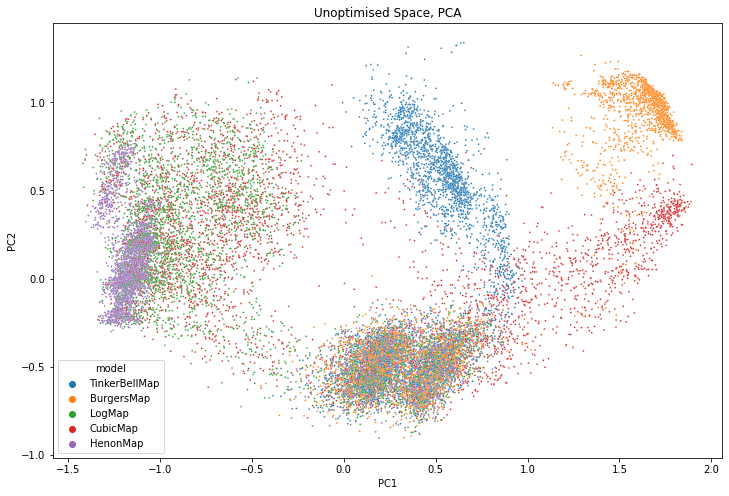

In [219]:
space.pcaViz()

## Logistic Map Identification

In [233]:
test_df, test_ts = generate_LogMap(20, 0.1)

In [220]:
num_iter = 100
identified = list()
Ns = np.linspace(20, 1000, 10, dtype=int)
for N in Ns:
    print(N)
    for i in range(num_iter):
        check_df, check_ts = generate_LogMap(N, eta_val=0.1)
        identified.append(isMap_isa(space, 'LogMap', check_df, check_ts))

20
128


KeyboardInterrupt: 

In [231]:
num_iter = 100
Ns = np.linspace(20, 1000, 10, dtype=int)
correct_per_N_SINDy = list()
correct_per_N_ISA = list()
for N in Ns:
    print(N)
    results_SINDy = list()
    results_ISA = list()
    for it in range(num_iter):
        check_df, check_ts = generate_CubicMap(N, eta_val=0.1)
        results_SINDy.append(isCubicMap_sindy(check_ts))
        results_ISA.append(isMap_isa(space, 'CubicMap', check_df, check_ts))
    correct_identifications_SINDy = np.count_nonzero(results_SINDy)
    correct_identifications_ISA = np.count_nonzero(results_ISA)
    correct_per_N_SINDy.append(correct_identifications_SINDy)
    correct_per_N_ISA.append(correct_identifications_ISA)
proportion_correct_SINDy = np.array(correct_per_N_SINDy)/num_iter
proportion_correct_ISA = np.array(correct_per_N_ISA)/num_iter


20
128
237
346
455
564
673
782
891
1000


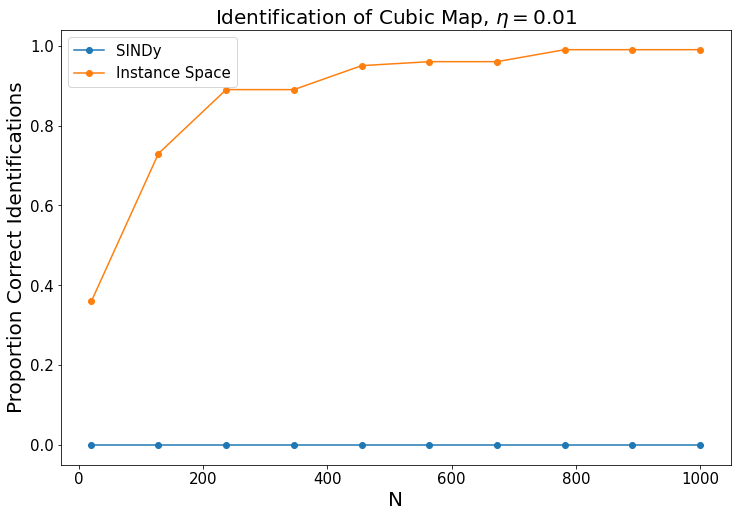

In [232]:
plt.figure(figsize=(12,8))
plt.title('Identification of Cubic Map, $\eta = 0.01$', fontsize=20)
plt.plot(Ns, proportion_correct_SINDy, label='SINDy', linestyle='-', marker='o')
plt.plot(Ns, proportion_correct_ISA, label='Instance Space', linestyle='-', marker='o')
plt.legend(fontsize=15)
plt.xlabel('N', fontsize=20)
plt.ylabel('Proportion Correct Identifications', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()